In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

In [3]:
import glob
from chainer import datasets

def create_dataset(img_filenames, label_filenames):
    img = datasets.ImageDataset(img_filenames)
    img = datasets.TransformDataset(img, lambda x: x / 255.)  # 0-1に正規化
    label = datasets.ImageDataset(label_filenames, dtype=np.int32)
    dataset = datasets.TupleDataset(img, label)
    return dataset

In [4]:
def create_datasets():
    # Python標準のglobを使ってMRI画像ファイル名/ラベル画像ファイル名の一覧を取得
    train_img_filenames = sorted(glob.glob('../../Class/BraTS2020_png_training/Flair/*.png'))
    train_label_filenames = sorted(glob.glob('../../Class/BraTS2020_png_training/Seg/*.png'))

    # リストを渡して，データセットオブジェクト train を作成
    train = create_dataset(train_img_filenames, train_label_filenames)

    # 同様のことをvalidationデータに対しても行う
    val_img_filenames = sorted(glob.glob('../../Class/BraTS2020_png_validation/Flair/*.png'))
    val_label_filenames = sorted(glob.glob('../../Class/BraTS2020_png_validation/Seg/*.png'))
    val = create_dataset(val_img_filenames, val_label_filenames)

    return train, val

In [5]:
train, val = create_datasets()

print('Dataset size:\n\ttrain:\t{}\n\tvalid:\t{}'.format(len(train), len(val)))

Dataset size:
	train:	7750
	valid:	1550


In [6]:
import chainer
import chainer.functions as F
import chainer.links as L

class MultiLayerPerceptron(chainer.Chain):

    def __init__(self, out_h, out_w):
        super().__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, 100)
            self.l2 = L.Linear(100, 100)
            self.l3 = L.Linear(100, out_h * out_w)
        self.out_h = out_h
        self.out_w = out_w

    def forward(self, x):
        h = F.relu(self.l1(x))
        h = F.relu(self.l2(h))
        h = self.l3(h)
        n = x.shape[0]

        return h.reshape((n, 1, self.out_h, self.out_w))

In [7]:
from chainer import iterators
from chainer import training
from chainer import optimizers
from chainer.training import extensions

def create_trainer(batchsize, train, val, stop, device=-1):
    # 先程定義したモデルを使用
    model = MultiLayerPerceptron(out_h=240, out_w=240)

    # ピクセルごとの二値分類なので，目的関数にSigmoid cross entropyを，
    # 精度をはかる関数としてBinary accuracyを指定しています
    train_model = L.Classifier(
        model, lossfun=F.sigmoid_cross_entropy, accfun=F.binary_accuracy)

    # 最適化手法にAdamを使います
    optimizer = optimizers.Adam()
    optimizer.setup(train_model)

    # データセットから，指定したバッチサイズ数のデータ点をまとめて取り出して返すイテレータを定義します
    train_iter = iterators.MultiprocessIterator(train, batchsize)
    val_iter = iterators.MultiprocessIterator(val, batchsize, repeat=False, shuffle=False)

    # イテレータからデータを引き出し，モデルに渡して，目的関数の値を計算し，backwardしてパラメータを更新，
    # までの一連の処理を行う updater を定義します
    updater = training.StandardUpdater(train_iter, optimizer, device=device)

    # 様々な付加機能をExtensionとして与えられるTrainerを使います
    trainer = training.trainer.Trainer(updater, stop)

    logging_attributes = [
        'epoch', 'main/loss', 'main/accuracy', 'val/main/loss', 'val/main/accuracy']
    trainer.extend(extensions.LogReport(logging_attributes))
    trainer.extend(extensions.PrintReport(logging_attributes))
    trainer.extend(extensions.PlotReport(['main/loss', 'val/main/loss'], 'epoch', file_name='loss.png'))
    trainer.extend(extensions.PlotReport(['main/accuracy', 'val/main/accuracy'], 'epoch', file_name='accuracy.png'))
    trainer.extend(extensions.Evaluator(val_iter, optimizer.target, device=device), name='val')

    return trainer

In [8]:
trainer = create_trainer(64, train, val, (20, 'epoch'), device =-1)
trainer.run()

epoch       main/loss   main/accuracy  val/main/loss  val/main/accuracy
1           0.241731    0.926807       0.111054       0.989992           
2           0.0529451   0.987766       0.116195       0.980848           
3           -0.0541908  0.981741       0.576643       0.971799           
4           -0.486593   0.980112       2.59789        0.971015           
5           -2.05253    0.979834       8.39665        0.970467           
6           -5.94467    0.979764       20.8975        0.967874           
7           -13.3938    0.979624       43.0662        0.972274           
8           -25.9288    0.979682       75.8775        0.970356           
9           -44.2025    0.979368       125.396        0.970832           
10          -70.1113    0.979233       191.911        0.968365           
11          -104.902    0.979144       280.712        0.970633           
12          -144.93     0.979033       387.819        0.969262           
13          -201.493    0.97879        5

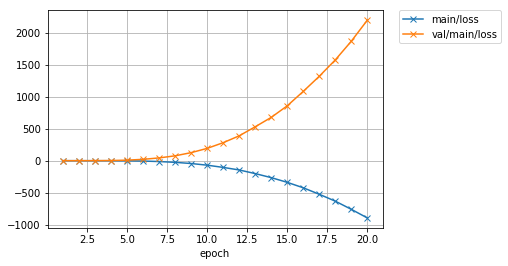

In [9]:
from IPython.display import Image
Image('result/loss.png')

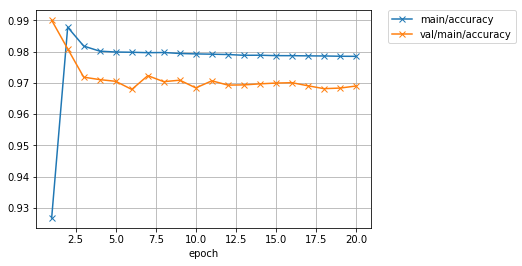

In [10]:
Image('result/accuracy.png')

In [11]:
from chainer import cuda
from chainercv import evaluations


def evaluate(trainer, val, device=-1):
    # Trainerオブジェクトから学習済みモデルを取り出す
    model = trainer.updater.get_optimizer('main').target.predictor
     # validationデータ全部に対して予測を行う
    preds = []
    for img, label in val:
        pred = model(img[np.newaxis])
        pred = pred.data[0, 0] > 0
        preds.append((pred, label[0]))
    pred_labels, gt_labels = zip(*preds)

    # 評価をして結果を表示
    evals = evaluations.eval_semantic_segmentation(pred_labels, gt_labels)
    print('Pixel Accuracy:', evals['pixel_accuracy'])
    print('mIoU:', evals['miou'])

evaluate(trainer, val, device =0)


Pixel Accuracy: 0.9685658826164875
mIoU: 0.24520513153457155


/anaconda3/lib/python3.7/site-packages/chainercv/evaluations/eval_semantic_segmentation.py:91: RuntimeWarning: invalid value encountered in true_divide
  iou = np.diag(confusion) / iou_denominator
/anaconda3/lib/python3.7/site-packages/chainercv/evaluations/eval_semantic_segmentation.py:168: RuntimeWarning: invalid value encountered in true_divide
  class_accuracy = np.diag(confusion) / np.sum(confusion, axis=1)


In [15]:
# 全畳み込みネットワーク
from chainer import reporter
from chainer import cuda
from chainercv import evaluations


class FullyConvolutionalNetwork(chainer.Chain):

    def __init__(self, out_h, out_w, n_class=1):
        super().__init__()
        with self.init_scope():
            # L.Convolution2D(in_ch, out_ch, ksize, stride, pad)
            # in_chは省略することができるので，
            # L.Convolution2D(out_ch, ksize, stride, pad)
            # とかくこともできます．
            self.conv1 = L.Convolution2D(None, 64, ksize=5, stride=2, pad=2)
            self.conv2 = L.Convolution2D(None, 128, ksize=5, stride=2, pad=2)
            self.conv3 = L.Convolution2D(None, 128, ksize=3, stride=1, pad=1)
            self.conv4 = L.Convolution2D(None, 128, ksize=3, stride=1, pad=1)
            self.conv5 = L.Convolution2D(None, 128, ksize=1, stride=1, pad=0)
            # L.Deconvolution2D(in_ch, out_ch, ksize, stride, pad)
            # in_chは省略することができるので，
            # L.Deconvolution2D(out_ch, ksize, stride, pad)
            # と書くこともできます．
            self.deconv6 = L.Deconvolution2D(None, n_class, ksize=32, stride=16, pad=8)
        self.out_h = out_h
        self.out_w = out_w

    def forward(self, x):
        h = F.relu(self.conv1(x))
        h = F.max_pooling_2d(h, 2, 2)

        h = F.relu(self.conv2(h))
        h = F.max_pooling_2d(h, 2, 2)

        h = F.relu(self.conv3(h))
        h = F.relu(self.conv4(h))
        h = self.conv5(h)
        h = self.deconv6(h)

        return h.reshape(x.shape[0], 1, h.shape[2], h.shape[3])

print(FullyConvolutionalNetwork(256, 256)(np.zeros((1, 1, 256, 256), dtype=np.float32)).shape[2:])

(256, 256)


In [16]:
class PixelwiseSigmoidClassifier(chainer.Chain):

    def __init__(self, predictor):
        super().__init__()
        with self.init_scope():
            # 学習対象のモデルをpredictorとして保持しておく
            self.predictor = predictor

    def __call__(self, x, t):
        # 学習対象のモデルでまず推論を行う
        y = self.predictor(x)

        # 2クラス分類の誤差を計算
        loss = F.sigmoid_cross_entropy(y, t)

        # 予測結果（0~1の連続値を持つグレースケール画像）を二値化し，
        # ChainerCVのeval_semantic_segmentation関数に正解ラベルと
        # 共に渡して各種スコアを計算
        y, t = cuda.to_cpu(F.sigmoid(y).data), cuda.to_cpu(t)
        y = np.asarray(y > 0.5, dtype=np.int32)
        y, t = y[:, 0, ...], t[:, 0, ...]
        evals = evaluations.eval_semantic_segmentation(y, t)

        # 学習中のログに出力
        reporter.report({'loss': loss,
                         'miou': evals['miou'],
                         'pa': evals['pixel_accuracy']}, self)
        return loss

In [17]:
def create_trainer(batchsize, train, val, stop, device=-1, log_trigger=(1, 'epoch')):
    model = FullyConvolutionalNetwork(out_h=256, out_w=256)
    train_model = PixelwiseSigmoidClassifier(model)

    optimizer = optimizers.Adam(eps=1e-05)
    optimizer.setup(train_model)

    train_iter = iterators.MultiprocessIterator(train, batchsize)
    val_iter = iterators.MultiprocessIterator(val, batchsize, repeat=False, shuffle=False)

    updater = training.StandardUpdater(train_iter, optimizer, device=device)

    trainer = training.trainer.Trainer(updater, stop, out='result_fcn')

    logging_attributes = [
        'epoch', 'main/loss', 'main/miou', 'main/pa',
        'val/main/loss', 'val/main/miou', 'val/main/pa']
    trainer.extend(extensions.LogReport(logging_attributes), trigger=log_trigger)
    trainer.extend(extensions.PrintReport(logging_attributes), trigger=log_trigger)
    trainer.extend(extensions.PlotReport(['main/loss', 'val/main/loss'], 'epoch', file_name='loss.png'))
    trainer.extend(extensions.PlotReport(['main/miou', 'val/main/miou'], 'epoch', file_name='miou.png'))
    trainer.extend(extensions.PlotReport(['main/pa', 'val/main/pa'], 'epoch', file_name='pa.png'))
    trainer.extend(extensions.Evaluator(val_iter, train_model, device=device), name='val')
    trainer.extend(extensions.dump_graph('main/loss'))
    return trainer

In [ ]:
%%time
trainer = create_trainer(128, train, val, (200, 'epoch'), device=-1, log_trigger=(10, 'epoch'))
trainer.run()

/anaconda3/lib/python3.7/site-packages/chainercv/evaluations/eval_semantic_segmentation.py:91: RuntimeWarning: invalid value encountered in true_divide
  iou = np.diag(confusion) / iou_denominator
/anaconda3/lib/python3.7/site-packages/chainercv/evaluations/eval_semantic_segmentation.py:168: RuntimeWarning: invalid value encountered in true_divide
  class_accuracy = np.diag(confusion) / np.sum(confusion, axis=1)
/anaconda3/lib/python3.7/site-packages/chainercv/evaluations/eval_semantic_segmentation.py:91: RuntimeWarning: invalid value encountered in true_divide
  iou = np.diag(confusion) / iou_denominator
/anaconda3/lib/python3.7/site-packages/chainercv/evaluations/eval_semantic_segmentation.py:168: RuntimeWarning: invalid value encountered in true_divide
  class_accuracy = np.diag(confusion) / np.sum(confusion, axis=1)


epoch       main/loss   main/miou   main/pa     val/main/loss  val/main/miou  val/main/pa
10          -1.81655e+08  0.265334    0.98117     4.77e+08       0.30392        0.974577     
20          -4.22445e+10  0.257289    0.973537    1.13046e+11    0.301912       0.966464     
30          -3.64283e+11  0.264535    0.983512    1.7213e+12     0.303763       0.973843     
40          -2.42476e+12  0.260508    0.979846    9.98078e+12    0.303054       0.971009     
50          -1.33033e+13  0.262625    0.976679    3.58196e+13    0.30323        0.971789     
60          -2.99221e+13  0.262524    0.983417    9.69319e+13    0.303362       0.972248     
70          -9.05699e+13  0.263486    0.978126    2.15487e+14    0.302941       0.970622     
80          -1.46231e+14  0.267554    0.978887    4.26546e+14    0.303058       0.97103      
90          -2.95467e+14  0.263113    0.979988    7.73341e+14    0.303164       0.971468     
100         -3.57009e+14  0.263741    0.979394    1.32636e+15   